In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person
from tqdm import tqdm
import json
import tensorflow as tf
import numpy as np
sys.path.append("../")
from utils import prewhiten, l2_normalize
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

In [2]:
model_path = '/home/ivan/pascal_adversarial_faces/keras-facenet/model/facenet_keras.h5'

In [3]:
auth_file = "/home/ivan/azure_auth.json"
with open(auth_file, "r") as f:
    auth_data = json.loads(f.read())
face_client = FaceClient(
    auth_data["endpoint"], 
    CognitiveServicesCredentials(auth_data["key"])
)

In [4]:
model = tf.keras.models.load_model(model_path)

In [5]:
def load_image_for_vggface(
    path,
    crop_box,
    resize_size=160
):
    img = Image.open(path).convert("RGB").crop(crop_box).resize((resize_size, resize_size))
    img = prewhiten(np.array(img)).astype(np.float32)
    return img

def load_cropped_images(paths_list):
    final_imgs = []
    for img_path in paths_list:
        results = face_client.face.detect_with_stream(
            open(img_path, "r+b"), 
            detectionModel='detection_02'
        )
        crop_box = (
            results[0].face_rectangle.left,
            results[0].face_rectangle.top,
            results[0].face_rectangle.left + results[0].face_rectangle.width,
            results[0].face_rectangle.top + results[0].face_rectangle.height
        )
        final_imgs.append(load_image_for_vggface(img_path, crop_box))
    return final_imgs

In [6]:
yoshi_paths = glob.glob("/data/ivan_yoshi_pascal/yoshi_*")
ivan_paths = glob.glob("/data/ivan_yoshi_pascal/ivan_*")

In [7]:
yoshi_images = load_cropped_images(yoshi_paths)

In [9]:
ivan_images = load_cropped_images(ivan_paths)

In [ ]:
def roc_curve(positive, negative):
    roc_auc = roc_auc_score(
        [1 for x in positive] + [0 for x in negative],
        np.concatenate((positive, negative), axis=0), 
    )
    print(f"Computed ROC AUC: {roc_auc:.3f}")
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="ResNet50 VGGFace2")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

In [11]:
def sanity_check(model, ivan_images, yoshi_images):
    yoshi_embeddings = model.predict(np.array(yoshi_images), batch_size=6)
    yoshi_embeddings = l2_normalize(yoshi_embeddings)
    
    ivan_embeddings = model.predict(np.array(ivan_images), batch_size=6)
    ivan_embeddings = l2_normalize(ivan_embeddings)
    
    self_distances = pairwise_distances(
         ivan_embeddings,
         ivan_embeddings,
         metric='euclidean',
         n_jobs=4
    )
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(ivan_embeddings), k=-1)
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        ivan_embeddings,
        yoshi_embeddings,
        metric='euclidean',
        n_jobs=4
    ).flatten()

    roc_curve(self_distances, negative_distances)

In [12]:
sanity_check(ivan_images, y)

Computed ROC AUC: 0.013
**** Computing ROC curve *****


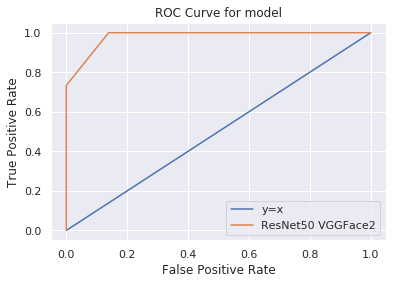